# Activity Classification using depth data



In [1]:
import scipy.io as sio
import numpy as np
import pickle
from skimage.transform import resize
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
from sklearn.metrics import confusion_matrix
from xgboost.sklearn import XGBClassifier
import matplotlib.pyplot as plt

### Pre-define parameters for modelling



In [2]:
trial_end = 4
subject_end =8
activity_end = 27
scale = 0.25
pixels_size = int(240*320*scale)
test_size = 0.3

### Function to compute target outputs

In [3]:
def generate_y(activity_end, subject_end, trial_end):
    activities = []
    for activity in range(1,activity_end+1):
        for subject in range(1,subject_end+1):
            for trial in range(1,trial_end+1):
                activities.append(activity)
    return (np.array(activities))

### Function to compute depth motion maps

In [4]:
def compute_DMM(activity,subject,trial):
    filepath = 'Kinect2Dataset/Depth/a%s_s%s_t%s_depth.mat'% (activity,subject,trial)
    data = sio.loadmat(filepath)['d_depth']
    
    DMMf = np.zeros(shape=(240,320),dtype='int32')
    for frame in range(0,data.shape[2]-1):
        DMMf = DMMf + abs(data[:,:,frame+1].astype('int32') - data[:,:,frame].astype('int32'))
    empty_x, empty_y = [],[]
    for x in range(0,DMMf.shape[0]):
        if np.sum(DMMf[x,:])==0:
            empty_x.append(x)
    DMMf = np.delete(DMMf,empty_x,axis=0)
    for y in range(0,DMMf.shape[0]):
        if np.sum(DMMf[:,y])==0:
            empty_y.append(y)
    DMMf = np.delete(DMMf,empty_y,axis=1)
    DMMf = np.round(resize(DMMf, (120, 160),preserve_range=True),0).astype('int32')
    DMMf = np.interp(DMMf, (DMMf.min(), DMMf.max()), (0, 255))
    DMMf = DMMf.flatten().tolist()
    
    DMMs = np.zeros(shape=(240,data.shape[2]),dtype='int32')
    for width in range(0,data.shape[1]-1):
        DMMs = DMMs + abs(data[:,width+1,:].astype('int32') - data[:,width,:].astype('int32'))
    empty_x, empty_y = [],[]
    for x in range(0,DMMs.shape[0]):
        if np.sum(DMMs[x,:])==0:
            empty_x.append(x)
    DMMs = np.delete(DMMs,empty_x,axis=0)
    for y in range(0,DMMs.shape[0]):
        if np.sum(DMMs[y,:])==0:
            empty_y.append(y)
    DMMs = np.delete(DMMs,empty_y,axis=1)
    DMMs = np.round(resize(DMMs, (120, 160),preserve_range=True),0).astype('int32')
    DMMs = np.interp(DMMs, (DMMs.min(), DMMs.max()), (0, 255))
    DMMs = DMMs.flatten().tolist()
    
    DMMt = np.zeros(shape=(320,data.shape[2]),dtype='int32')
    for height in range(0,data.shape[0]-1):
        DMMt = DMMt + abs(data[height+1,:,:].astype('int32') - data[height,:,:].astype('int32'))
    empty_x, empty_y = [],[]
    for x in range(0,DMMt.shape[0]):
        if np.sum(DMMt[x,:])==0:
            empty_x.append(x)
    DMMt = np.delete(DMMt,empty_x,axis=0)
    for y in range(0,DMMt.shape[0]):
        if np.sum(DMMt[y,:])==0:
            empty_y.append(y)
    DMMt = np.delete(DMMt,empty_y,axis=1)
    DMMt = np.round(resize(DMMt, (120, 160),preserve_range=True),0).astype('int')
    DMMt = np.interp(DMMt, (DMMt.min(), DMMt.max()), (0, 255))
    DMMt = DMMt.flatten().tolist()
    
    return ([DMMf+DMMs+DMMt])

### Function to compute depth data inputs

In [5]:
def compute_depth_data(activity_end, subject_end, trial_end):
    depth_data = np.empty(shape=(0,3*120*160),dtype = 'int32')
    for activity in range(1,activity_end+1):
        print('loading activity %s' % (activity))
        for subject in range(1,subject_end+1):
            for trial in range(1,trial_end+1):
                depth_data = np.append(depth_data,compute_DMM(activity,subject,trial),axis=0)
    return (depth_data)

### Function to compute confusion matrix

In [6]:
def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    import itertools
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix')

    #print(cm)

    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=90)
    plt.yticks(tick_marks, classes)

    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    plt.tight_layout()

### Compute depth data inputs

In [7]:
depth_data = compute_depth_data(activity_end, subject_end, trial_end)

picklesave = open("depth_data.pickle", "wb")
pickle.dump(depth_data, picklesave)
picklesave.close()

loading activity 1


C:\Users\ltylt\Anaconda3\lib\site-packages\skimage\transform\_warps.py:84: UserWarning: The default mode, 'constant', will be changed to 'reflect' in skimage 0.15.
  warn("The default mode, 'constant', will be changed to 'reflect' in "


loading activity 2
loading activity 3
loading activity 4
loading activity 5
loading activity 6
loading activity 7
loading activity 8
loading activity 9
loading activity 10
loading activity 11
loading activity 12
loading activity 13
loading activity 14
loading activity 15
loading activity 16
loading activity 17
loading activity 18
loading activity 19
loading activity 20
loading activity 21
loading activity 22
loading activity 23
loading activity 24
loading activity 25
loading activity 26
loading activity 27


### Compute target outputs



In [8]:
y = generate_y(activity_end, subject_end, trial_end)

### Preparing training sets and testing sets

In [9]:
xtrain, xtest, ytrain, ytest = train_test_split(depth_data, y, test_size=test_size, random_state=1)

### XGboost model for depth data classification

In [10]:
xgb_model = XGBClassifier(max_depth=4, n_estimators = 100, nthread = 2, objective= 'multi:softmax')
xgb_model = xgb_model.fit(xtrain, ytrain, eval_metric=['mlogloss'], eval_set=[((xtrain, ytrain)),(xtest, ytest)])

picklesave = open("xgb_model.pickle", "wb")
pickle.dump(xgb_model, picklesave)
picklesave.close()

[0]	validation_0-mlogloss:2.74054	validation_1-mlogloss:2.96034
[1]	validation_0-mlogloss:2.33925	validation_1-mlogloss:2.7188
[2]	validation_0-mlogloss:2.01268	validation_1-mlogloss:2.52461
[3]	validation_0-mlogloss:1.75591	validation_1-mlogloss:2.37466
[4]	validation_0-mlogloss:1.54776	validation_1-mlogloss:2.25376
[5]	validation_0-mlogloss:1.37715	validation_1-mlogloss:2.15417
[6]	validation_0-mlogloss:1.23184	validation_1-mlogloss:2.06381
[7]	validation_0-mlogloss:1.10832	validation_1-mlogloss:1.9862
[8]	validation_0-mlogloss:1.00108	validation_1-mlogloss:1.91721
[9]	validation_0-mlogloss:0.907326	validation_1-mlogloss:1.8584
[10]	validation_0-mlogloss:0.823485	validation_1-mlogloss:1.79641
[11]	validation_0-mlogloss:0.748209	validation_1-mlogloss:1.73643
[12]	validation_0-mlogloss:0.681367	validation_1-mlogloss:1.68114
[13]	validation_0-mlogloss:0.621269	validation_1-mlogloss:1.62913
[14]	validation_0-mlogloss:0.567483	validation_1-mlogloss:1.57918
[15]	validation_0-mlogloss:0.519

In [11]:
yprob = xgb_model.predict_proba(xtest)

picklesave = open("yprob.pickle", "wb")
pickle.dump(yprob, picklesave)
picklesave.close()

In [12]:
ypred = xgb_model.predict(xtest)
accuracy = accuracy_score(ytest, ypred)
accuracy

C:\Users\ltylt\Anaconda3\lib\site-packages\sklearn\preprocessing\label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


0.8192307692307692

### Plot confusion matrix

Confusion matrix


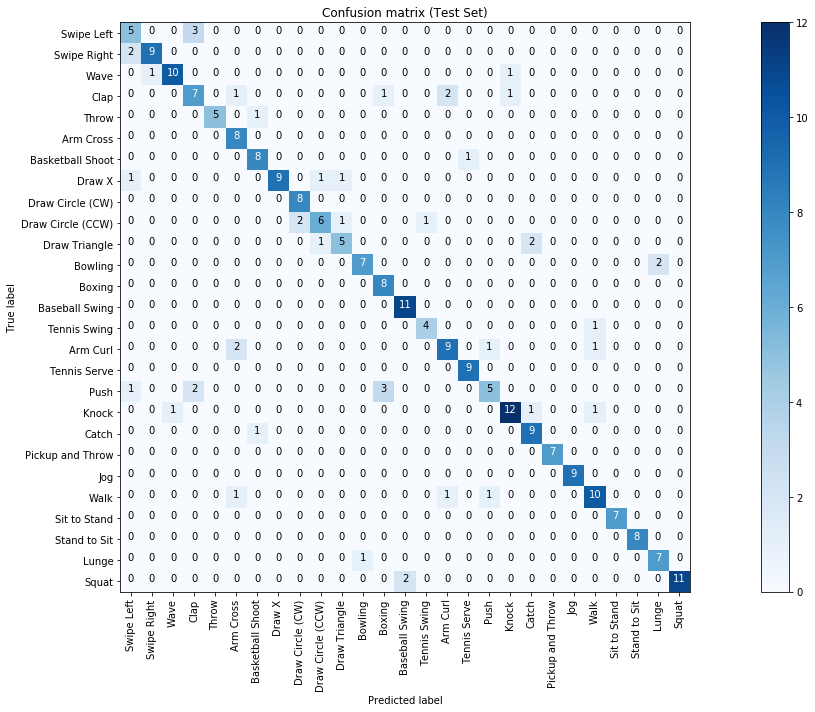

In [13]:
cnf_matrix = confusion_matrix(ytest, ypred)
np.set_printoptions(precision=2)
target_names = ['Swipe Left', 'Swipe Right', 'Wave', 'Clap', 'Throw', 'Arm Cross', 'Basketball Shoot', 
                'Draw X', 'Draw Circle (CW)', 'Draw Circle (CCW)', 'Draw Triangle', 'Bowling', 'Boxing', 
                'Baseball Swing', 'Tennis Swing', 'Arm Curl', 'Tennis Serve', 'Push', 'Knock', 'Catch',
                'Pickup and Throw', 'Jog', 'Walk', 'Sit to Stand', 'Stand to Sit', 'Lunge', 'Squat']
plt.figure(figsize=(20,10))
plot_confusion_matrix(cnf_matrix, classes=target_names,
                      title='Confusion matrix (Test Set)')
plt.show()

In [18]:
from sklearn.metrics import classification_report

report = classification_report(ytest, ypred, target_names = target_names)
print(report)

                   precision    recall  f1-score   support

       Swipe Left       0.56      0.62      0.59         8
      Swipe Right       0.90      0.82      0.86        11
             Wave       0.91      0.83      0.87        12
             Clap       0.58      0.58      0.58        12
            Throw       1.00      0.83      0.91         6
        Arm Cross       0.67      1.00      0.80         8
 Basketball Shoot       0.80      0.89      0.84         9
           Draw X       1.00      0.75      0.86        12
 Draw Circle (CW)       0.80      1.00      0.89         8
Draw Circle (CCW)       0.75      0.60      0.67        10
    Draw Triangle       0.71      0.62      0.67         8
          Bowling       0.88      0.78      0.82         9
           Boxing       0.67      1.00      0.80         8
   Baseball Swing       0.85      1.00      0.92        11
     Tennis Swing       0.80      0.80      0.80         5
         Arm Curl       0.75      0.69      0.72       